## Poisson VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Poisson base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

We run each scenario 5 times and compare the fit with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
βtrue = ones(p)
Σtrue = [0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; Σtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.150203039
 0.110564592
 0.044110654
 0.100172423
 0.188676163
 0.942790876
 0.038824237
 0.115664679
 0.041563363
 0.057245101
 0.132465535
 0.041204641
 0.189369039
 ⋮
 4.593222184
 9.195408219
 4.7079249
 5.193508727
 8.621820988
 4.764341822
 4.520244025
 5.03628938
 9.640884733
 2.945314098
 4.796830353
 9.660612977

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
  3.145848212
  0.031347829
  0.021502702
  0.096274859
  0.110565417
  0.156316705
  0.017680053
  0.020469941
  0.018057207
  0.018442308
  0.019633857
  0.01939386
  0.088038708
  ⋮
 17.976465678
 16.864779208
 17.473525019
 18.241538522
 18.600202505
 16.529206046
 19.291411168
 18.119387555
 19.962115545
 18.653953751
 18.110598636
 20.400488772

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0768269,0.00983253,200,0.0669944,0.0964919,0.000384134
2,100,5,0.0855785,0.0110041,500,0.0745744,0.107587,0.000171157
3,100,10,0.0737676,0.00769766,1000,0.0660699,0.0891629,7.37676e-5
4,100,15,0.0743852,0.00384958,1500,0.0705356,0.0820844,4.95901e-5
5,100,20,0.103674,0.00609198,2000,0.0975824,0.115858,5.18372e-5
6,100,25,0.0961164,0.00438808,2500,0.0917284,0.104893,3.84466e-5
7,1000,2,0.112512,0.0049146,2000,0.107597,0.122341,5.62558e-5
8,1000,5,0.164958,0.00902642,5000,0.155931,0.183011,3.29916e-5
9,1000,10,0.255941,0.0126152,10000,0.243325,0.281171,2.55941e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,NaN,NaN,200,NaN,NaN,NaN
2,100,5,0.0529597,0.0050773,500,0.0478824,0.058037,0.000105919
3,100,10,0.0772468,0.0045613,1000,0.0726855,0.0818081,7.72468e-5
4,100,15,0.105336,0.000997361,1500,0.104339,0.106334,7.02242e-5
5,100,20,0.168277,0.0120335,2000,0.156243,0.18031,8.41385e-5
6,100,25,0.18631,0.00880232,2500,0.177508,0.195113,7.45242e-5
7,1000,2,NaN,NaN,2000,NaN,NaN,NaN
8,1000,5,NaN,NaN,5000,NaN,NaN,NaN
9,1000,10,NaN,NaN,10000,NaN,NaN,NaN


In [8]:
# ########### plot the runtimes
# using RCall
# @rput timedf1
# @rput timedf2
# R"""
# library(ggplot2)
# library(cowplot)
# timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
# timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

# fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
#   geom_line() +
#   geom_point()+
#   geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=13),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#    scale_color_manual(values = c("#c85f55",
# "#a964bf",
# "#8db352",
# "#fa7300",
# "#05aec0",
# "#ff1493")) +
#   labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

# timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
# timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

# fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
#   geom_line() +
#   geom_point()+
#   geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=13),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#    scale_color_manual(values = c("#c85f55",
# "#a964bf",
# "#8db352",
# "#fa7300",
# "#05aec0",
# "#ff1493")) +
#   labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

# fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
# """

# R"""
# ggsave('fittime_nsamples_poisson_vs_glmm.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
# """

In [9]:
# using RCall
# @rput timedf1
# @rput timedf2

# R"""
# library(scales)
# library(ggplot2)
# timedf1$obssize <- factor(timedf1$obssize, levels = c('2', '5', '10', '20', '50'))
# timedf1$samplesize <- factor(timedf1$samplesize, levels = c('1000', '10000', '100000'))

# fancy_scientific <- function(l) {
#      # turn in to character string in scientific notation
#      l <- format(l, scientific = TRUE)
#      # quote the part before the exponent to keep all the digits
#      l <- gsub("^(.*)e", "'\\1'e", l)
#      # turn the 'e+' into plotmath format
#      l <- gsub("e", "%*%10^", l)
#      # return this as an expression
#      parse(text=l)
# }

# fittimeperobs1 = ggplot(timedf1, aes(x=nobs, y=perobsratio)) + 
#   geom_line() +
#   geom_point()+
# #  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=11),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#   labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
# #scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
# scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
# scale_y_continuous(breaks = c(10^-5, 2 * 10^-5, 3 * 10^-5, 4 * 10^-5, 5 * 10^-5, 6 * 10^-5, 7  * 10^-5, 8  * 10^-5 , 9  * 10^-5, 10^-4), labels= fancy_scientific)

# # glmm fit times
# timedf2$obssize <- factor(timedf2$obssize, levels = c('2', '5', '10', '20', '50'))
# timedf2$samplesize <- factor(timedf2$samplesize, levels = c('1000', '10000', '100000'))

# fancy_scientific <- function(l) {
#      # turn in to character string in scientific notation
#      l <- format(l, scientific = TRUE)
#      # quote the part before the exponent to keep all the digits
#      l <- gsub("^(.*)e", "'\\1'e", l)
#      # turn the 'e+' into plotmath format
#      l <- gsub("e", "%*%10^", l)
#      # return this as an expression
#      parse(text=l)
# }

# fittimeperobs2 = ggplot(timedf2, aes(x=nobs, y=perobsratio)) + 
#   geom_line() +
#   geom_point()+
# #  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=11),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#   labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
# #scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
# scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
# scale_y_continuous(breaks = c(10^-5, 2 * 10^-5, 3 * 10^-5, 4 * 10^-5, 5 * 10^-5, 6 * 10^-5, 7  * 10^-5, 8  * 10^-5 , 9  * 10^-5, 10^-4), labels= fancy_scientific)

# fittime_perobs = plot_grid(fittimeperobs1, fittimeperobs2, labels = c("Quasi-Copula", "GLMM"))

# """

# R"""
# ggsave('fittime_perobs_poisson_vs_glmm.png', fittime_perobs, width = 12.5, height = 15, units = 'in', dpi = 450)
# """

In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βΣcoverage = readdlm("beta_sigma_coverage_multivariate_poisson_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,Σ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.8, 0.0402015)","(0.58, 0.0496045)","(0.76, 0.0429235)","(0.95, 0.0219043)"
2,N: 100 ni: 5,"(0.87, 0.0337998)","(0.61, 0.0490207)","(0.8, 0.0402015)","(0.92, 0.027266)"
3,N: 100 ni: 10,"(0.8, 0.0402015)","(0.68, 0.0468826)","(0.8, 0.0402015)","(0.96, 0.0196946)"
4,N: 100 ni: 15,"(0.7, 0.0460566)","(0.64, 0.0482418)","(0.8, 0.0402015)","(0.96, 0.0196946)"
5,N: 100 ni: 20,"(0.56, 0.0498888)","(0.59, 0.0494311)","(0.78, 0.0416333)","(0.96, 0.0196946)"
6,N: 100 ni: 25,"(0.61, 0.0490207)","(0.71, 0.0456048)","(0.84, 0.0368453)","(0.94, 0.0238683)"
7,N: 1000 ni: 2,"(0.89, 0.0314466)","(0.44, 0.0498888)","(0.64, 0.0482418)","(0.9, 0.0301511)"
8,N: 1000 ni: 5,"(0.67, 0.0472582)","(0.58, 0.0496045)","(0.75, 0.0435194)","(0.94, 0.0238683)"
9,N: 1000 ni: 10,"(0.32, 0.0468826)","(0.55, 0.05)","(0.71, 0.0456048)","(0.9, 0.0301511)"


In [11]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresultpoisson = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

βMseresultpoisson_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
ΣMseresultpoisson_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresultpoisson, Σmse = ΣMseresultpoisson, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresultpoisson_GLMM, Σmse = ΣMseresultpoisson_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :Sigmamse]; msedf2[!, :betamse]; msedf2[!, :Sigmamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :Sigma]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Poisson Quasi-Copula"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Poisson GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.00264974,2,100,beta,Poisson Quasi-Copula
2,0.0015374,2,100,beta,Poisson Quasi-Copula
3,0.000202976,2,100,beta,Poisson Quasi-Copula
4,1.54881e-5,2,100,beta,Poisson Quasi-Copula
5,0.00223349,2,100,beta,Poisson Quasi-Copula
6,0.00593353,2,100,beta,Poisson Quasi-Copula
7,0.00138477,2,100,beta,Poisson Quasi-Copula
8,0.000122743,2,100,beta,Poisson Quasi-Copula
9,0.000524323,2,100,beta,Poisson Quasi-Copula


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


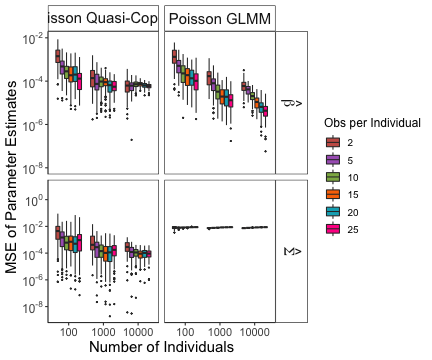

RObject{VecSxp}


In [12]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'Sigma'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(Sigma))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Poisson Quasi-Copula', 'Poisson GLMM'),
    labels = c(expression(paste("Poisson Quasi-Copula")), expression(paste("Poisson GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [13]:
R"""
ggsave('updated_msefacetplot_poisson.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_poisson.png"
